In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import skimage
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
import sys
import sqlite3
import shutil
from scipy import stats
from time import time
sys.path.append(os.environ['REPO_DIR'])
from lib.utils import configuration, run
from matplotlib.path import Path
from shapely.geometry import Polygon

In [2]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y


def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [3]:
stack = 'MD594'
section = 115
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}


fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')
contours_struc = contours.groupby('name')
valid_sections = np.sort(contours['section'].unique())

fn = 'CSHL_data_processed/MD589/ThresholdsV2.pkl'
setup_download_from_s3(fn, recursive=False)
thresholds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [4]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

margin = 200/0.46

In [5]:
polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]

db_dir = 'CSHL_databases/' + stack + '/'
db_fp = db_dir + str(section) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()

ALREADY DOWNLOADED FILE


In [6]:
section, margin

(115, 434.78260869565213)

In [6]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape

ALREADY DOWNLOADED FILE


In [8]:
raws = cur.execute('SELECT * FROM features')
info = np.array(list(raws))
locations = info[:, 1:3]
features_all = info[:, 3:]

polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]
polygon = polygons[0][1]


In [9]:
[left, right, up, down] = [int(max(min(polygon[:, 0]), 0)),
                           int(min(np.ceil(max(polygon[:, 0]) ),n)),
                           int(max(min(polygon[:, 1]), 0)),
                           int(min(np.ceil(max(polygon[:, 1]) ),m))]
raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
info = np.array(list(raws))
locations = info[:, 1:3]
features = info[:, 3:]

In [10]:
features.shape

(2174, 20)

In [10]:
origin= ['area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width', 'density', 'area_ratio']

In [11]:
from scipy import stats

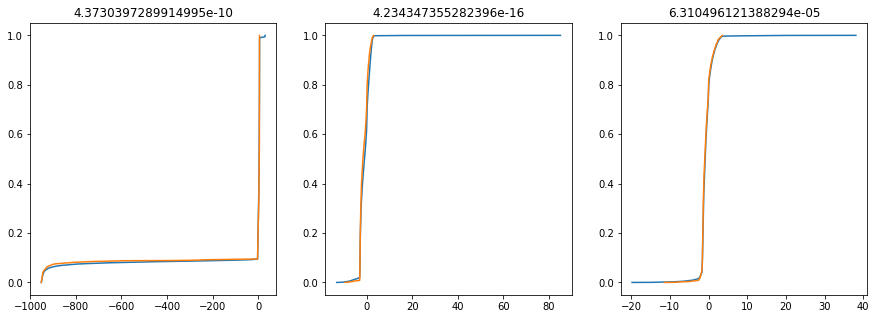

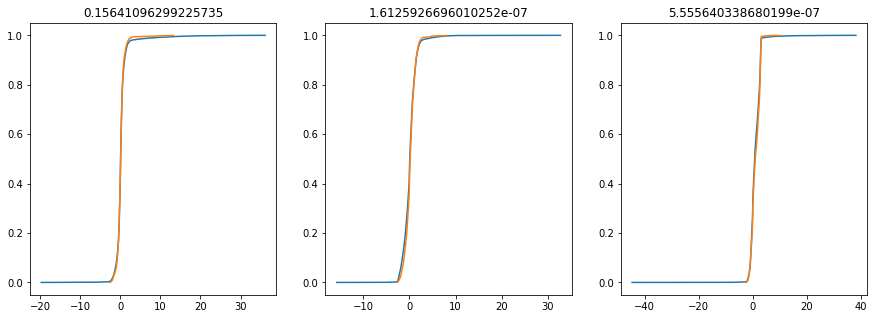

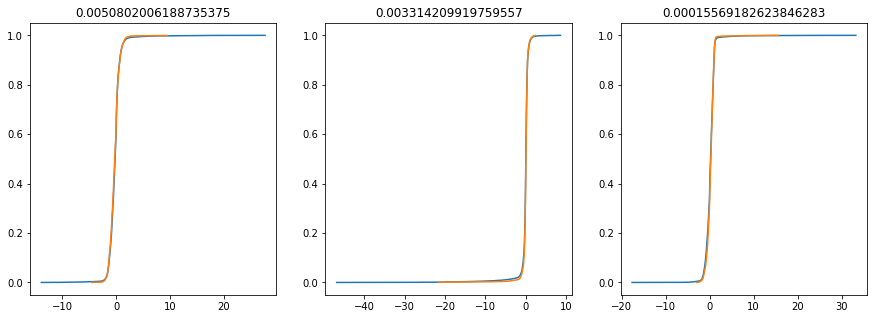

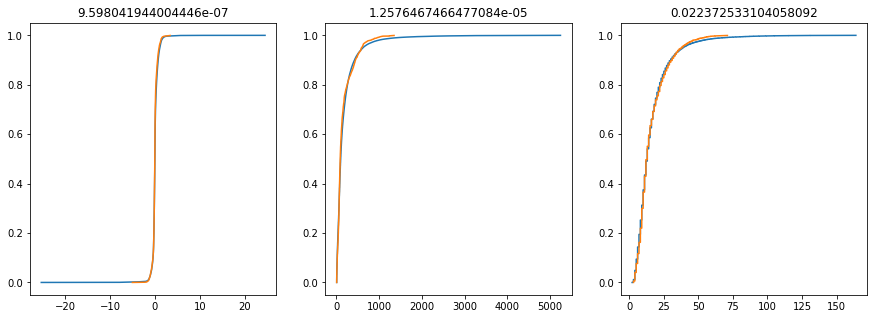

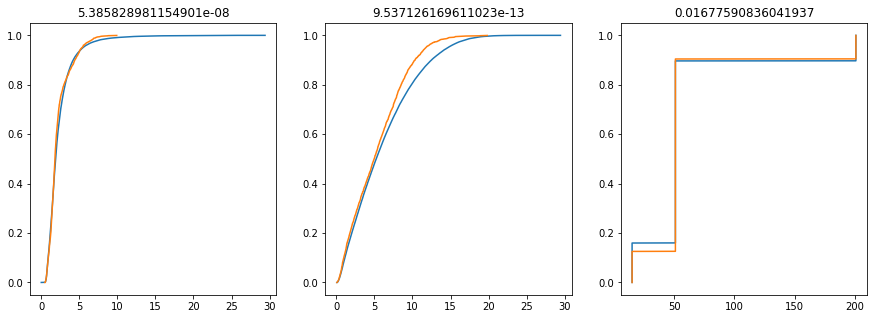

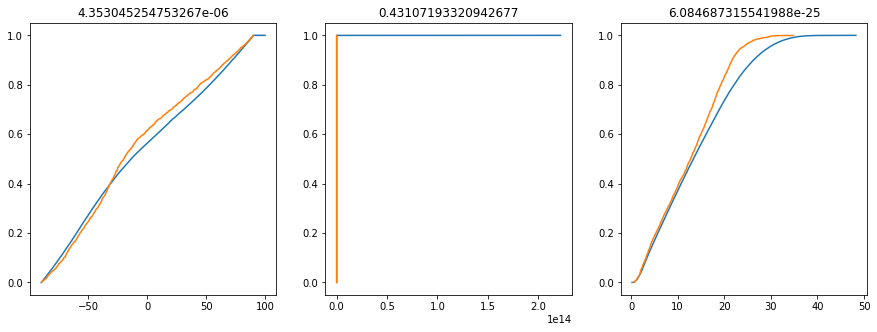

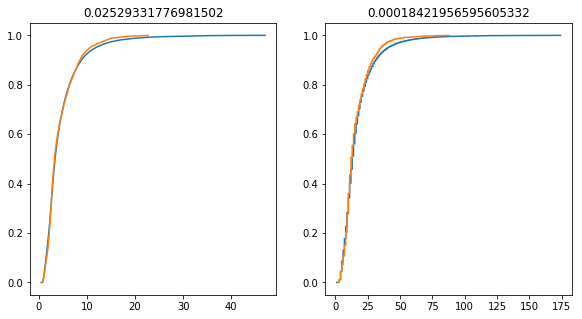

In [45]:
for i in range(20):
    if i%3==0:
        plt.figure(figsize=(15,5))
    plt.subplot(1,3,i%3+1)
    x1, y1 = CDF(features_all[:,i])
    plt.plot(x1, y1)
    x2, y2 = CDF(features[:,i])
    plt.plot(x2, y2)
    eva = stats.ks_2samp(x1, x2)[1]
    plt.title(str(eva))

In [26]:
rvs1 = stats.norm.rvs(size=2000, loc=0., scale=1.5)
rvs2 = stats.norm.rvs(size=70000, loc=0.5, scale=1.5)
stats.ks_2samp(rvs1, rvs2)

Ks_2sampResult(statistic=0.14698571428571428, pvalue=4.066107951570837e-37)

In [32]:
np.unique(rvs1)

array([-4.63799375, -4.59819621, -4.470213  , ...,  4.19595033,
        4.47661614,  5.03652608])

In [12]:
for i in range(20):
    x1, y1 = CDF(features_all[:,i])
    x2, y2 = CDF(features[:,i])
    xmin = max(x1.min(), x2.min())
    xmax = min(x1.max(), x2.max())
    index_min1 = np.argmin(np.absolute(x1-xmin))
    index_max1 = np.argmin(np.absolute(x1-xmax))
    index_min2 = np.argmin(np.absolute(x2-xmin))
    index_max2 = np.argmin(np.absolute(x2-xmax))
    eva = stats.ks_2samp(x1[index_min1:index_max1], x2[index_min2:index_max2+1])[1]
    print(eva)

1.424424343624118e-11
6.685470587385582e-16
7.14399159387282e-05
0.3344315008105045
2.6726790630013073e-07
3.1759611437144816e-07
0.0031397899056627827
0.003443365380829379
0.0004925144368014493
1.752916291798421e-06
0.00012229463028800487
0.01331914019142803
1.1278488366945566e-06
5.446534733262215e-12
0.0061734430690208765
4.8246433967791846e-06
0.4501208621142755
4.715487878937727e-22
0.020060153676609287
0.00044231218484166133


In [59]:
index_max1, index_max2, index_min1, index_min2

(78620, 10694, 1, 0)

In [14]:
%%time
[left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                           int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
                           int(max(min(polygon[:, 1]) - margin, 0)),
                           int(min(np.ceil(max(polygon[:, 1]) + margin), m))]
raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
info = np.array(list(raws))
locations = info[:, 1:3]
features = info[:, 3:]
stride = 56
window_size = 224
xs, ys = np.meshgrid(np.arange(left, right, stride), np.arange(up, down, stride), indexing='xy')
windows = np.c_[xs.flat, ys.flat]
hsv = np.zeros([m, n])

for index in range(len(windows)):
    print(index, len(windows))
    extracted = []
    wx = int(windows[index][0])
    wy = int(windows[index][1])
    indices_window = np.where((locations[:, 0] > wx) & (locations[:, 0] < wx + window_size) \
                              & (locations[:, 1] > wy) & (locations[:, 1] < wy + window_size))[0]
    if len(indices_window):
        cells = features[indices_window]
        eva = 1
        for i in range(20):
            x1, y1 = CDF(features_all[:,i])
            x2, y2 = CDF(cells[:,i])
#             xmin = max(x1.min(), x2.min())
#             xmax = min(x1.max(), x2.max())
#             index_min1 = np.argmin(np.absolute(x1-xmin))
#             index_max1 = np.argmin(np.absolute(x1-xmax))
#             index_min2 = np.argmin(np.absolute(x2-xmin))
#             index_max2 = np.argmin(np.absolute(x2-xmax))
#             eva.append(stats.ks_2samp(y1[index_min1:index_max1], y2[index_min2:index_max2+1])[1])
            eva *= 1 - stats.ks_2samp(x1, x2)[1]
            origin = hsv[wy: wy + window_size, wx: wx + window_size]
            satua_img = np.zeros_like(origin) + eva
            comp = np.absolute(origin) - np.absolute(satua_img)
            hsv[wy: wy + window_size, wx: wx + window_size] = origin * (comp > 0) + satua_img * (comp < 0)        

0 2016
1 2016
2 2016
3 2016
4 2016
5 2016
6 2016
7 2016
8 2016
9 2016
10 2016
11 2016
12 2016
13 2016
14 2016
15 2016
16 2016
17 2016
18 2016
19 2016
20 2016
21 2016
22 2016
23 2016
24 2016
25 2016
26 2016
27 2016
28 2016
29 2016
30 2016
31 2016
32 2016
33 2016
34 2016
35 2016
36 2016
37 2016
38 2016
39 2016
40 2016
41 2016
42 2016
43 2016
44 2016
45 2016
46 2016
47 2016
48 2016
49 2016
50 2016
51 2016
52 2016
53 2016
54 2016
55 2016
56 2016
57 2016
58 2016
59 2016
60 2016
61 2016
62 2016
63 2016
64 2016
65 2016
66 2016
67 2016
68 2016
69 2016
70 2016
71 2016
72 2016
73 2016
74 2016
75 2016
76 2016
77 2016
78 2016
79 2016
80 2016
81 2016
82 2016
83 2016
84 2016
85 2016
86 2016
87 2016
88 2016
89 2016
90 2016
91 2016
92 2016
93 2016
94 2016
95 2016
96 2016
97 2016
98 2016
99 2016
100 2016
101 2016
102 2016
103 2016
104 2016
105 2016
106 2016
107 2016
108 2016
109 2016
110 2016
111 2016
112 2016
113 2016
114 2016
115 2016
116 2016
117 2016
118 2016
119 2016
120 2016
121 2016
122 2016
123

923 2016
924 2016
925 2016
926 2016
927 2016
928 2016
929 2016
930 2016
931 2016
932 2016
933 2016
934 2016
935 2016
936 2016
937 2016
938 2016
939 2016
940 2016
941 2016
942 2016
943 2016
944 2016
945 2016
946 2016
947 2016
948 2016
949 2016
950 2016
951 2016
952 2016
953 2016
954 2016
955 2016
956 2016
957 2016
958 2016
959 2016
960 2016
961 2016
962 2016
963 2016
964 2016
965 2016
966 2016
967 2016
968 2016
969 2016
970 2016
971 2016
972 2016
973 2016
974 2016
975 2016
976 2016
977 2016
978 2016
979 2016
980 2016
981 2016
982 2016
983 2016
984 2016
985 2016
986 2016
987 2016
988 2016
989 2016
990 2016
991 2016
992 2016
993 2016
994 2016
995 2016
996 2016
997 2016
998 2016
999 2016
1000 2016
1001 2016
1002 2016
1003 2016
1004 2016
1005 2016
1006 2016
1007 2016
1008 2016
1009 2016
1010 2016
1011 2016
1012 2016
1013 2016
1014 2016
1015 2016
1016 2016
1017 2016
1018 2016
1019 2016
1020 2016
1021 2016
1022 2016
1023 2016
1024 2016
1025 2016
1026 2016
1027 2016
1028 2016
1029 2016
1030 20

1750 2016
1751 2016
1752 2016
1753 2016
1754 2016
1755 2016
1756 2016
1757 2016
1758 2016
1759 2016
1760 2016
1761 2016
1762 2016
1763 2016
1764 2016
1765 2016
1766 2016
1767 2016
1768 2016
1769 2016
1770 2016
1771 2016
1772 2016
1773 2016
1774 2016
1775 2016
1776 2016
1777 2016
1778 2016
1779 2016
1780 2016
1781 2016
1782 2016
1783 2016
1784 2016
1785 2016
1786 2016
1787 2016
1788 2016
1789 2016
1790 2016
1791 2016
1792 2016
1793 2016
1794 2016
1795 2016
1796 2016
1797 2016
1798 2016
1799 2016
1800 2016
1801 2016
1802 2016
1803 2016
1804 2016
1805 2016
1806 2016
1807 2016
1808 2016
1809 2016
1810 2016
1811 2016
1812 2016
1813 2016
1814 2016
1815 2016
1816 2016
1817 2016
1818 2016
1819 2016
1820 2016
1821 2016
1822 2016
1823 2016
1824 2016
1825 2016
1826 2016
1827 2016
1828 2016
1829 2016
1830 2016
1831 2016
1832 2016
1833 2016
1834 2016
1835 2016
1836 2016
1837 2016
1838 2016
1839 2016
1840 2016
1841 2016
1842 2016
1843 2016
1844 2016
1845 2016
1846 2016
1847 2016
1848 2016
1849 2016


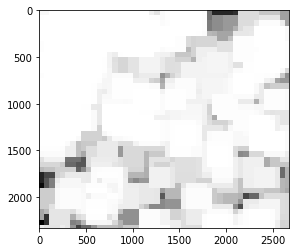

In [15]:
plt.imshow(hsv[up:down, left:right], cmap='gray')

In [16]:
ks_map = hsv[up:down, left:right].copy()

In [71]:
np.where(ks_map==ks_map.max())

(array([112, 112, 112, ..., 335, 335, 335]),
 array([ 952,  953,  954, ..., 1173, 1174, 1175]))

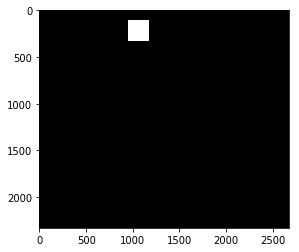

In [17]:
plt.imshow(ks_map==ks_map.max(),cmap='gray')

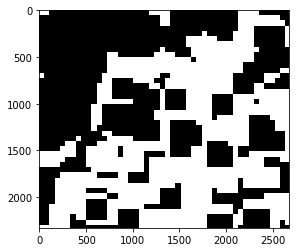

In [18]:
plt.imshow((0.995>ks_map) & (ks_map>0.9),cmap='gray')

In [17]:
polygon[:, 0] = polygon[:, 0] - left
polygon[:, 1] = polygon[:, 1] - up

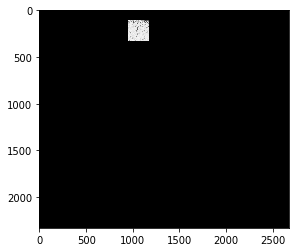

In [20]:
com = cv2.polylines(img[up:down, left:right].copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com*(ks_map==ks_map.max()), cmap='gray')

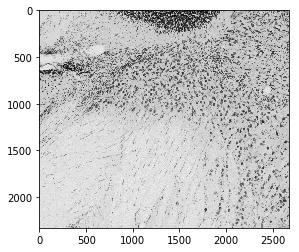

In [19]:
com = cv2.polylines(img[up:down, left:right].copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com, cmap='gray')

In [21]:
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')
polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]
polygon = polygons[0][1]

In [23]:
%%time
[left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                           int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
                           int(max(min(polygon[:, 1]) - margin, 0)),
                           int(min(np.ceil(max(polygon[:, 1]) + margin), m))]
stride = 56
window_size = 224
xs, ys = np.meshgrid(np.arange(left, right, stride), np.arange(up, down, stride), indexing='xy')
windows = np.c_[xs.flat, ys.flat]
hsv = np.zeros([m, n])

locations_all = []
features_all = []
locations_part = []
features_part = []

for i in range(5):
    db_dir = 'CSHL_databases/' + stack + '/'
    db_fp = db_dir + str(section+i) + '.db'
    setup_download_from_s3(db_fp, recursive=False)
    conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
    cur = conn.cursor() 
    
    raws = cur.execute('SELECT * FROM features')
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    locations_all.append(locations)
    features_all.append(features)
    
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    locations_part.append(locations)
    features_part.append(features)

ALREADY DOWNLOADED FILE
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/116.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/116.db


OperationalError: no such table: features

ALREADY DOWNLOADED FILE


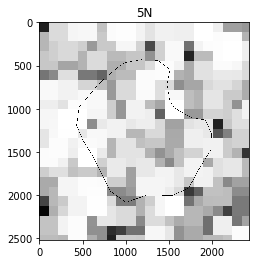

ALREADY DOWNLOADED FILE


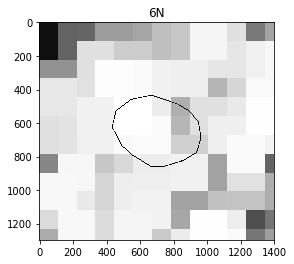

ALREADY DOWNLOADED FILE


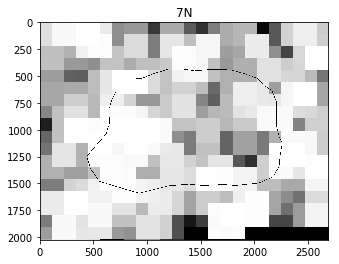

ALREADY DOWNLOADED FILE


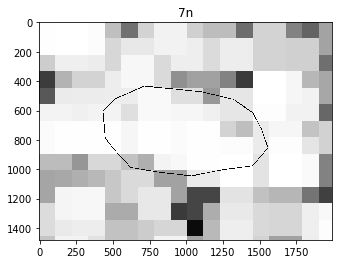

ALREADY DOWNLOADED FILE


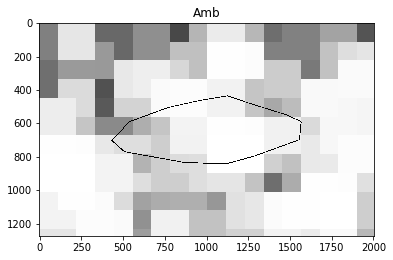

ALREADY DOWNLOADED FILE


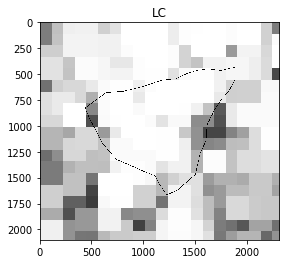

ALREADY DOWNLOADED FILE


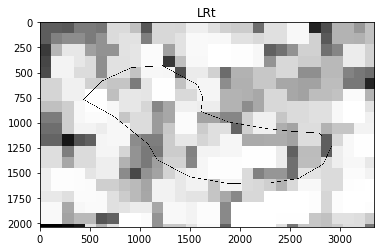

ALREADY DOWNLOADED FILE


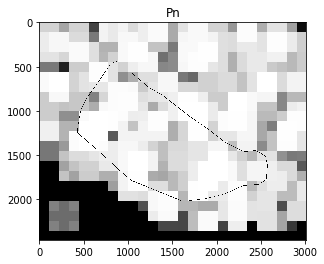

ALREADY DOWNLOADED FILE


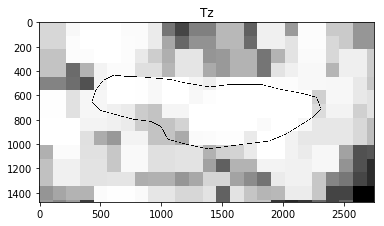

ALREADY DOWNLOADED FILE


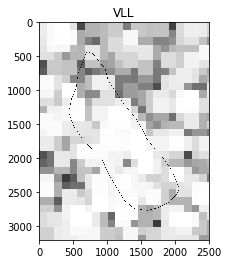

ALREADY DOWNLOADED FILE


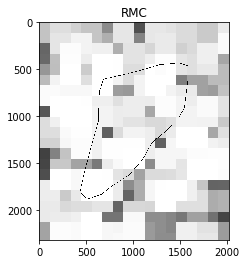

ALREADY DOWNLOADED FILE


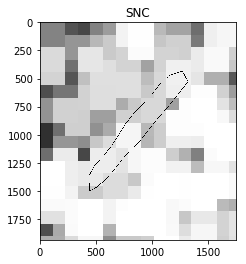

ALREADY DOWNLOADED FILE


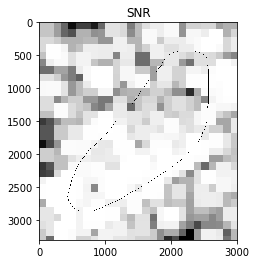

ALREADY DOWNLOADED FILE


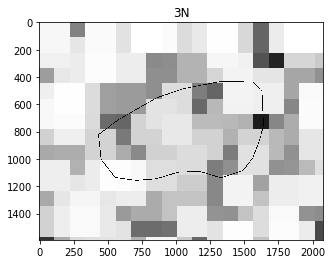

ALREADY DOWNLOADED FILE


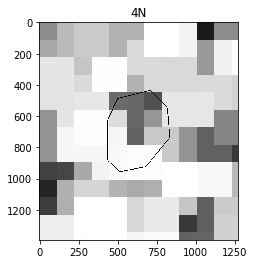

ALREADY DOWNLOADED FILE


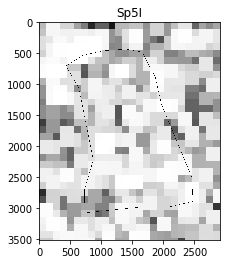

ALREADY DOWNLOADED FILE


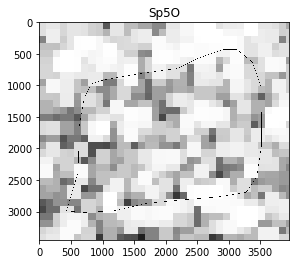

ALREADY DOWNLOADED FILE


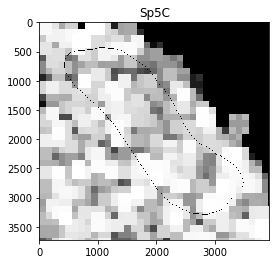

ALREADY DOWNLOADED FILE


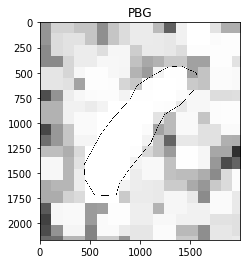

ALREADY DOWNLOADED FILE


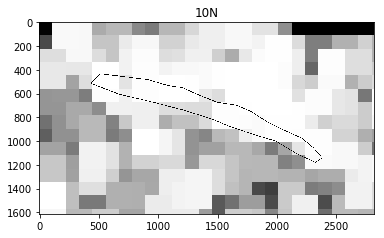

ALREADY DOWNLOADED FILE


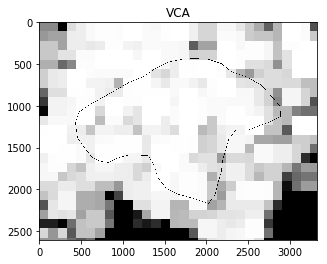

ALREADY DOWNLOADED FILE


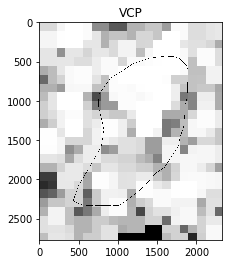

ALREADY DOWNLOADED FILE


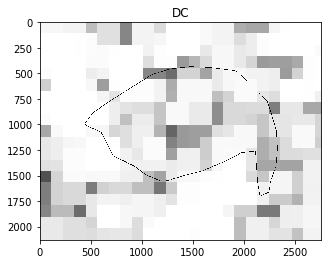

ALREADY DOWNLOADED FILE


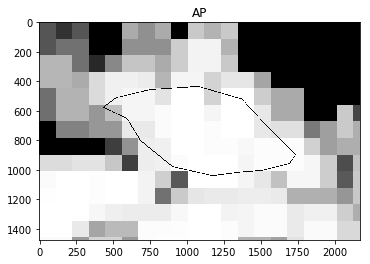

ALREADY DOWNLOADED FILE


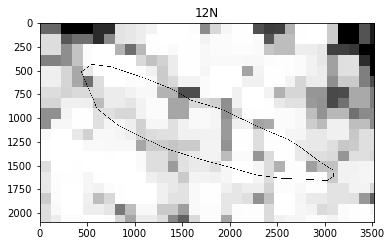

ALREADY DOWNLOADED FILE


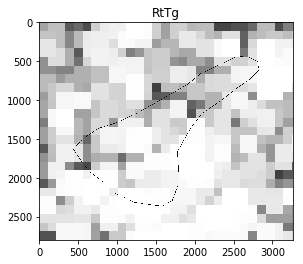

ALREADY DOWNLOADED FILE


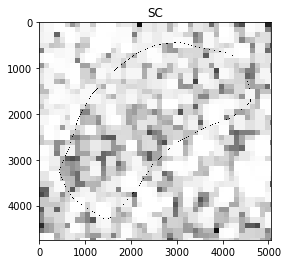

ALREADY DOWNLOADED FILE


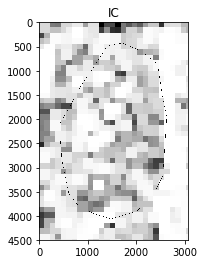

CPU times: user 1h 19min 47s, sys: 1min 5s, total: 1h 20min 52s
Wall time: 1h 21min 40s


In [21]:
%%time
count = 0
importances = {}
sort_by_imp = {}
for structure in all_structures:
#     if structure == '7n':
#         structure = '7nn'

#     fp = []
#     fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
#     fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
#     X_train = []
#     y_train = []
#     for state in range(2):
#         clouds = pickle.load(open(fp[state], 'rb'))
#         X_train.extend(np.array(clouds))
#         y_train.extend([1 - state] * len(clouds))

#     fp = []
#     fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
#     fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
#     for state in range(2):
#         clouds = pickle.load(open(fp[state], 'rb'))
#         X_train.extend(np.array(clouds))
#         y_train.extend([1 - state] * len(clouds))
#     X_train = np.array(X_train)
#     y_train = np.array(y_train)
#     dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
#     bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

#     if structure == '7nn':
#         structure = '7n'
    
    polygons = [(contour['section'], contour['vertices']) \
                for contour_id, contour in contours_struc.get_group(structure).iterrows()]
    area_max = 0
    for contour_id, contour in polygons:
        section = contour_id
        polygon = contour.copy()
        if Polygon(polygon).area>area_max:
            area_max = Polygon(polygon).area
            section_max = section
            polygon_max = polygon 
    polygon = polygon_max
    
    db_dir = 'CSHL_databases/' + stack + '/'
    db_fp = db_dir + str(section_max) + '.db'
    setup_download_from_s3(db_fp, recursive=False)
    conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
    cur = conn.cursor()   
    
    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin), m))]
    
    raws = cur.execute('SELECT * FROM features')
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features_all = info[:, 3:]
    
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    
#     path = Path(polygon)
#     indices_inside = np.where(path.contains_points(locations))[0]
#     features_inside = features[indices_inside]
#     locations_inside = locations[indices_inside]
    
#     surround = Polygon(polygon).buffer(margin, resolution=2)
#     path = Path(list(surround.exterior.coords))
#     indices_sur = np.where(path.contains_points(locations))[0]
#     indices_outside = np.setdiff1d(indices_sur, indices_inside)
#     features_outside = features[indices_outside]
#     locations_outside = locations[indices_outside]
    
#     gains = bst.get_score(importance_type='total_gain')
#     importances[structure] = {}
#     for feature in gains.keys():
#         if feature=='density'or feature=='area_ratio':
#             importances[structure][feature] = gains[feature]
#         else:
#             star = feature.rfind('*')
#             name = feature[:star]
#             if name not in importances[structure].keys():
#                 importances[structure][name] = {}
#             importances[structure][name][feature] = gains[feature]
#     features = importances[structure].keys()
#     scores = {}
#     for feature in features:
#         if feature=='density'or feature=='area_ratio':
#             scores[feature] = importances[structure][feature]
#         else:
#             total = np.array([importances[structure][feature][name] for name in importances[structure][feature].keys()]).sum()
#             scores[feature] = total
#     features_sorted = sorted(scores, key=scores.__getitem__, reverse=True)
#     sort_by_imp[structure] = features_sorted[:5]
    
    stride = 112
    window_size = 224
    xs, ys = np.meshgrid(np.arange(left, right, stride), np.arange(up, down, stride), indexing='xy')
    windows = np.c_[xs.flat, ys.flat]
    
    hsv = np.zeros([m, n])
    for index in range(len(windows)):
        extracted = []
        wx = int(windows[index][0])
        wy = int(windows[index][1])
        indices_window = np.where((locations[:, 0] > wx) & (locations[:, 0] < wx + window_size) \
                                  & (locations[:, 1] > wy) & (locations[:, 1] < wy + window_size))[0]
        if len(indices_window):
            cells = features[indices_window]
            eva = 1
            for i in range(20):
                x1, y1 = CDF(features_all[:,i])
                x2, y2 = CDF(cells[:,i])
    
                eva *= 1 - stats.ks_2samp(x1, x2)[1]
                origin = hsv[wy: wy + window_size, wx: wx + window_size]
                satua_img = np.zeros_like(origin) + eva
                comp = np.absolute(origin) - np.absolute(satua_img)
                hsv[wy: wy + window_size, wx: wx + window_size] = origin * (comp > 0) + satua_img * (comp < 0) 
    plt.figure()
    ks_map = hsv[up:down, left:right].copy()
    annotation = polygon.copy()
    annotation[:, 0] = annotation[:, 0] - left
    annotation[:, 1] = annotation[:, 1] - up
    com = cv2.polylines(ks_map, [annotation.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
    plt.imshow(com, cmap='gray')
    plt.title(structure)
    plt.show()

In [ ]:
'AP', 'PBG', 'VLL', 'Tz', '7n'

ALREADY DOWNLOADED FILE


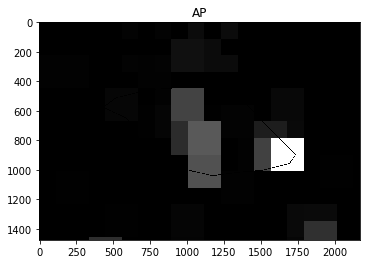

CPU times: user 1min 7s, sys: 480 ms, total: 1min 7s
Wall time: 1min 7s


In [73]:
%%time
#     if structure == '7n':
#         structure = '7nn'

#     fp = []
#     fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
#     fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
#     X_train = []
#     y_train = []
#     for state in range(2):
#         clouds = pickle.load(open(fp[state], 'rb'))
#         X_train.extend(np.array(clouds))
#         y_train.extend([1 - state] * len(clouds))

#     fp = []
#     fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
#     fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
#     for state in range(2):
#         clouds = pickle.load(open(fp[state], 'rb'))
#         X_train.extend(np.array(clouds))
#         y_train.extend([1 - state] * len(clouds))
#     X_train = np.array(X_train)
#     y_train = np.array(y_train)
#     dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
#     bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

#     if structure == '7nn':
#         structure = '7n'
structure = 'AP'
polygons = [(contour['section'], contour['vertices']) \
            for contour_id, contour in contours_struc.get_group(structure).iterrows()]
area_max = 0
for contour_id, contour in polygons:
    section = contour_id
    polygon = contour.copy()
    if Polygon(polygon).area>area_max:
        area_max = Polygon(polygon).area
        section_max = section
        polygon_max = polygon 
polygon = polygon_max

db_dir = 'CSHL_databases/' + stack + '/'
db_fp = db_dir + str(section_max) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()   

[left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                           int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
                           int(max(min(polygon[:, 1]) - margin, 0)),
                           int(min(np.ceil(max(polygon[:, 1]) + margin), m))]

raws = cur.execute('SELECT * FROM features')
info = np.array(list(raws))
locations = info[:, 1:3]
features_all = info[:, 3:]

raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
info = np.array(list(raws))
locations = info[:, 1:3]
features = info[:, 3:]
    
#     path = Path(polygon)
#     indices_inside = np.where(path.contains_points(locations))[0]
#     features_inside = features[indices_inside]
#     locations_inside = locations[indices_inside]
    
#     surround = Polygon(polygon).buffer(margin, resolution=2)
#     path = Path(list(surround.exterior.coords))
#     indices_sur = np.where(path.contains_points(locations))[0]
#     indices_outside = np.setdiff1d(indices_sur, indices_inside)
#     features_outside = features[indices_outside]
#     locations_outside = locations[indices_outside]
    
#     gains = bst.get_score(importance_type='total_gain')
#     importances[structure] = {}
#     for feature in gains.keys():
#         if feature=='density'or feature=='area_ratio':
#             importances[structure][feature] = gains[feature]
#         else:
#             star = feature.rfind('*')
#             name = feature[:star]
#             if name not in importances[structure].keys():
#                 importances[structure][name] = {}
#             importances[structure][name][feature] = gains[feature]
#     features = importances[structure].keys()
#     scores = {}
#     for feature in features:
#         if feature=='density'or feature=='area_ratio':
#             scores[feature] = importances[structure][feature]
#         else:
#             total = np.array([importances[structure][feature][name] for name in importances[structure][feature].keys()]).sum()
#             scores[feature] = total
#     features_sorted = sorted(scores, key=scores.__getitem__, reverse=True)
#     sort_by_imp[structure] = features_sorted[:5]
    
stride = 112
window_size = 224
xs, ys = np.meshgrid(np.arange(left, right, stride), np.arange(up, down, stride), indexing='xy')
windows = np.c_[xs.flat, ys.flat]

hsv = np.zeros([m, n])
for index in range(len(windows)):
    extracted = []
    wx = int(windows[index][0])
    wy = int(windows[index][1])
    indices_window = np.where((locations[:, 0] > wx) & (locations[:, 0] < wx + window_size) \
                              & (locations[:, 1] > wy) & (locations[:, 1] < wy + window_size))[0]
    if len(indices_window):
        cells = features[indices_window]
        eva = 1
        for i in range(20):
            x1, y1 = CDF(features_all[:,i])
            x2, y2 = CDF(cells[:,i])

            eva *= 1 - stats.ks_2samp(x1, x2)[1]
        origin = hsv[wy: wy + window_size, wx: wx + window_size]
        satua_img = np.zeros_like(origin) + eva
        comp = np.absolute(origin) - np.absolute(satua_img)
        hsv[wy: wy + window_size, wx: wx + window_size] = origin * (comp > 0) + satua_img * (comp < 0) 
plt.figure()
ks_map = hsv[up:down, left:right].copy()
annotation = polygon.copy()
annotation[:, 0] = annotation[:, 0] - left
annotation[:, 1] = annotation[:, 1] - up
com = cv2.polylines(ks_map, [annotation.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com, cmap='gray')
plt.title(structure)
plt.show()

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


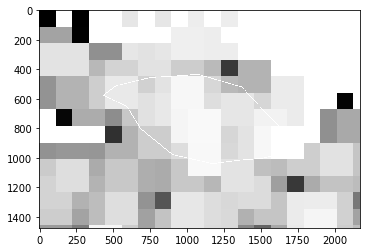

In [78]:
plt.imshow(np.log(ks_map), cmap='gray')

In [25]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section_max] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)

ALREADY DOWNLOADED FILE


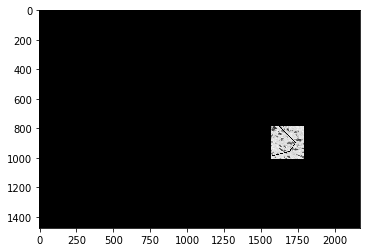

In [74]:
com = cv2.polylines(img[up:down, left:right].copy(), [annotation.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com*(ks_map==ks_map.max()), cmap='gray')

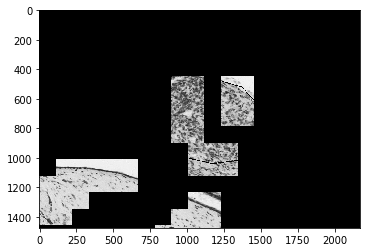

In [33]:
com = cv2.polylines(img[up:down, left:right].copy(), [annotation.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com*(ks_map>0.99), cmap='gray')

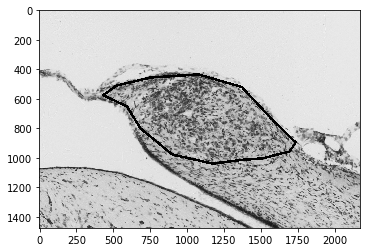

In [37]:
com = cv2.polylines(img[up:down, left:right].copy(), [annotation.astype(np.int32)], True, [0, 255, 0], 15, lineType=8)
plt.imshow(com, cmap='gray')

ALREADY DOWNLOADED FILE


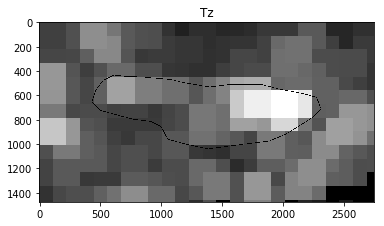

CPU times: user 52.2 s, sys: 394 ms, total: 52.5 s
Wall time: 53.4 s


In [11]:
%%time
#     if structure == '7n':
#         structure = '7nn'

#     fp = []
#     fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
#     fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
#     X_train = []
#     y_train = []
#     for state in range(2):
#         clouds = pickle.load(open(fp[state], 'rb'))
#         X_train.extend(np.array(clouds))
#         y_train.extend([1 - state] * len(clouds))

#     fp = []
#     fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
#     fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
#     for state in range(2):
#         clouds = pickle.load(open(fp[state], 'rb'))
#         X_train.extend(np.array(clouds))
#         y_train.extend([1 - state] * len(clouds))
#     X_train = np.array(X_train)
#     y_train = np.array(y_train)
#     dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
#     bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

#     if structure == '7nn':
#         structure = '7n'
structure = 'Tz'
polygons = [(contour['section'], contour['vertices']) \
            for contour_id, contour in contours_struc.get_group(structure).iterrows()]
area_max = 0
for contour_id, contour in polygons:
    section = contour_id
    polygon = contour.copy()
    if Polygon(polygon).area>area_max:
        area_max = Polygon(polygon).area
        section_max = section
        polygon_max = polygon 
polygon = polygon_max

db_dir = 'CSHL_databases/' + stack + '/'
db_fp = db_dir + str(section_max) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()   

[left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                           int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
                           int(max(min(polygon[:, 1]) - margin, 0)),
                           int(min(np.ceil(max(polygon[:, 1]) + margin), m))]

raws = cur.execute('SELECT * FROM features')
info = np.array(list(raws))
locations = info[:, 1:3]
features_all = info[:, 3:]

raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
info = np.array(list(raws))
locations = info[:, 1:3]
features = info[:, 3:]
    
#     path = Path(polygon)
#     indices_inside = np.where(path.contains_points(locations))[0]
#     features_inside = features[indices_inside]
#     locations_inside = locations[indices_inside]
    
#     surround = Polygon(polygon).buffer(margin, resolution=2)
#     path = Path(list(surround.exterior.coords))
#     indices_sur = np.where(path.contains_points(locations))[0]
#     indices_outside = np.setdiff1d(indices_sur, indices_inside)
#     features_outside = features[indices_outside]
#     locations_outside = locations[indices_outside]
    
#     gains = bst.get_score(importance_type='total_gain')
#     importances[structure] = {}
#     for feature in gains.keys():
#         if feature=='density'or feature=='area_ratio':
#             importances[structure][feature] = gains[feature]
#         else:
#             star = feature.rfind('*')
#             name = feature[:star]
#             if name not in importances[structure].keys():
#                 importances[structure][name] = {}
#             importances[structure][name][feature] = gains[feature]
#     features = importances[structure].keys()
#     scores = {}
#     for feature in features:
#         if feature=='density'or feature=='area_ratio':
#             scores[feature] = importances[structure][feature]
#         else:
#             total = np.array([importances[structure][feature][name] for name in importances[structure][feature].keys()]).sum()
#             scores[feature] = total
#     features_sorted = sorted(scores, key=scores.__getitem__, reverse=True)
#     sort_by_imp[structure] = features_sorted[:5]
    
stride = 112
window_size = 224
xs, ys = np.meshgrid(np.arange(left, right, stride), np.arange(up, down, stride), indexing='xy')
windows = np.c_[xs.flat, ys.flat]
p_values = np.zeros((len(windows), 20))
samples = []
for i in range(20):
    x1, y1 = CDF(features_all[:,i])
    samples.append(x1)

hsv = np.zeros([m, n])
for index in range(len(windows)):
    extracted = []
    wx = int(windows[index][0])
    wy = int(windows[index][1])
    indices_window = np.where((locations[:, 0] > wx) & (locations[:, 0] < wx + window_size) \
                              & (locations[:, 1] > wy) & (locations[:, 1] < wy + window_size))[0]
    if len(indices_window):
        cells = features[indices_window]
        eva = 0
        p_value = []
        for i in range(20):
            x1 = samples[i]
            x2, y2 = CDF(cells[:,i])
            value = stats.ks_2samp(x1, x2)[1]
            eva += - np.log(value)
            p_value.append(value)
        p_values[index] = np.array(p_value)
        origin = hsv[wy: wy + window_size, wx: wx + window_size]
        satua_img = np.zeros_like(origin) + eva
        comp = np.absolute(origin) - np.absolute(satua_img)
        hsv[wy: wy + window_size, wx: wx + window_size] = origin * (comp > 0) + satua_img * (comp < 0) 
plt.figure()
ks_map = hsv[up:down, left:right].copy()
annotation = polygon.copy()
annotation[:, 0] = annotation[:, 0] - left
annotation[:, 1] = annotation[:, 1] - up
com = cv2.polylines(ks_map, [annotation.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com, cmap='gray')
plt.title(structure)
plt.show()

In [14]:
p_values[0]

array([0.15829611, 0.1917672 , 0.62485896, 0.35104569, 0.03648437,
       0.09809442, 0.04006062, 0.23542571, 0.49973811, 0.86235369,
       0.2399677 , 0.3499167 , 0.18028673, 0.28530506, 0.98317081,
       0.18286464, 0.44195012, 0.24964908, 0.36401562, 0.2301352 ])

In [12]:
p_values.shape

(350, 20)

In [133]:
len(windows), len(p_values)

(350, 0)

In [41]:
x1.shape,x2.shape

((116800,), (1,))

In [35]:
p_values=np.array(p_values)
p_values.shape

(321,)

In [36]:
p_values_nz=p_values[p_values>0]
p_values_nz.shape

(294,)

(array([222.,  40.,  16.,   8.,  14.,   7.,   9.,   1.,   3.,   1.]),
 array([2.32322506e-09, 1.99506317e-02, 3.99012610e-02, 5.98518904e-02,
        7.98025197e-02, 9.97531491e-02, 1.19703778e-01, 1.39654408e-01,
        1.59605037e-01, 1.79555666e-01, 1.99506296e-01]),
 <a list of 10 Patch objects>)

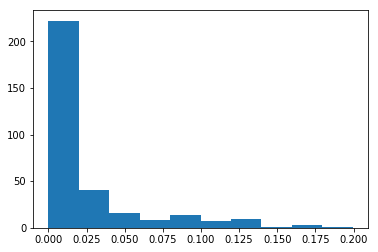

In [50]:
plt.hist(p_values)

(array([ 3.,  4., 14., 12., 28., 32., 43., 60., 70., 28.]),
 array([-57.30573809, -51.78099629, -46.25625448, -40.73151268,
        -35.20677087, -29.68202906, -24.15728726, -18.63254545,
        -13.10780365,  -7.58306184,  -2.05832003]),
 <a list of 10 Patch objects>)

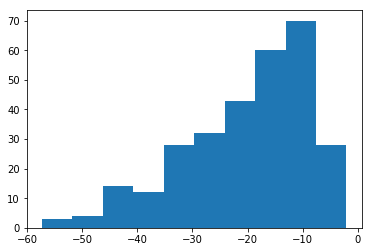

In [38]:
plt.hist(np.log(p_values_nz))

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


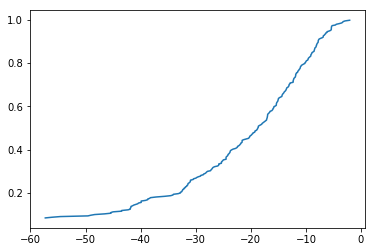

In [39]:
plt.figure()
x,y = CDF(np.log(p_values))
plt.plot(x,y)

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


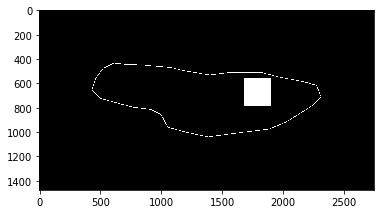

In [70]:
plt.imshow(np.log(ks_map), cmap='gray')

ALREADY DOWNLOADED FILE


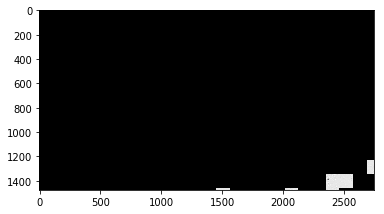

In [67]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section_max] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
com = cv2.polylines(img[up:down, left:right].copy(), [annotation.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com*(ks_map==ks_map.min()), cmap='gray')

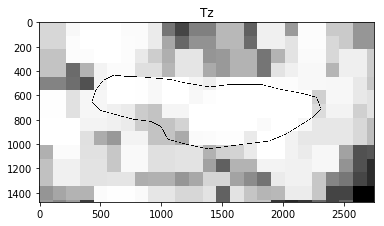

In [13]:
com = cv2.polylines(ks_map, [annotation.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com, cmap='gray')
plt.title(structure)
plt.savefig('/Users/kuiqian/Desktop/features/example.png')

ALREADY DOWNLOADED FILE


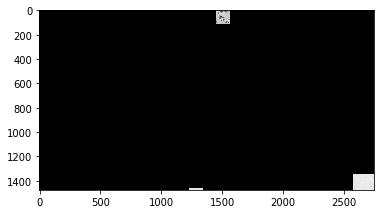

In [66]:
stack = 'MD594'
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section_max] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
com = cv2.polylines(img[up:down, left:right].copy(), [annotation.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com*(ks_map==ks_map.max()), cmap='gray')

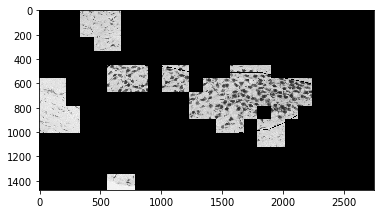

In [11]:
com = cv2.polylines(img[up:down, left:right].copy(), [annotation.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com*(ks_map>0.99), cmap='gray')

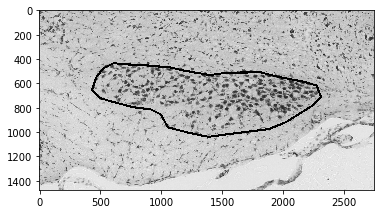

In [40]:
com = cv2.polylines(img[up:down, left:right].copy(), [annotation.astype(np.int32)], True, [0, 255, 0], 15, lineType=8)
plt.imshow(com, cmap='gray')

In [62]:
stack = 'MD585'
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
fn = 'MD585-IHC38-2015.07.16-17.00.35_MD585_2_0113_prep2_lossless_gray.tif'
setup_download_from_s3(raw_images_root + fn, recursive=False)

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_prep2_lossless_gray/MD585-IHC38-2015.07.16-17.00.35_MD585_2_0113_prep2_lossless_gray.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_prep2_lossless_gray/MD585-IHC38-2015.07.16-17.00.35_MD585_2_0113_prep2_lossless_gray.tif


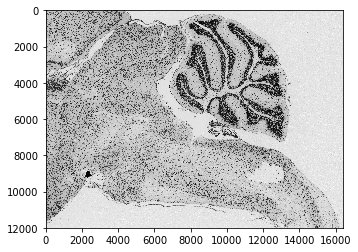

In [63]:
img = cv2.imread(os.environ['ROOT_DIR']+raw_images_root + fn, 2)
plt.imshow(img, cmap='gray')

In [84]:
m,n

(11104, 17216)

ALREADY DOWNLOADED FILE


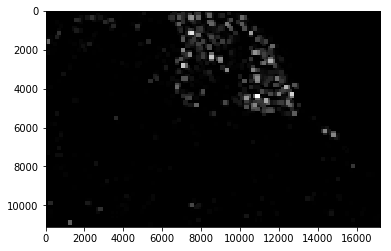

CPU times: user 1h 6min 47s, sys: 1min, total: 1h 7min 47s
Wall time: 1h 8min 35s


In [85]:
%%time
structure = 'Tz'
polygons = [(contour['section'], contour['vertices']) \
            for contour_id, contour in contours_struc.get_group(structure).iterrows()]
area_max = 0
for contour_id, contour in polygons:
    section = contour_id
    polygon = contour.copy()
    if Polygon(polygon).area>area_max:
        area_max = Polygon(polygon).area
        section_max = section
        polygon_max = polygon 
polygon = polygon_max

db_dir = 'CSHL_databases/' + stack + '/'
db_fp = db_dir + str(section_max) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()   

# [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
#                            int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
#                            int(max(min(polygon[:, 1]) - margin, 0)),
#                            int(min(np.ceil(max(polygon[:, 1]) + margin), m))]

raws = cur.execute('SELECT * FROM features')
info = np.array(list(raws))
locations = info[:, 1:3]
features_all = info[:, 3:]

# raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
# info = np.array(list(raws))
# locations = info[:, 1:3]
# features = info[:, 3:]
    

stride = 112
window_size = 224
xs, ys = np.meshgrid(np.arange(0, n, stride), np.arange(0, m, stride), indexing='xy')
windows = np.c_[xs.flat, ys.flat]
p_values = []

hsv = np.zeros([m, n])
for index in range(len(windows)):
    wx = int(windows[index][0])
    wy = int(windows[index][1])
    indices_window = np.where((locations[:, 0] > wx) & (locations[:, 0] < wx + window_size) \
                              & (locations[:, 1] > wy) & (locations[:, 1] < wy + window_size))[0]
    if len(indices_window):
        cells = features_all[indices_window]
        eva = 1
        for i in range(20):
            x1, y1 = CDF(features_all[:,i])
            x2, y2 = CDF(cells[:,i])
#             eva.append(stats.ks_2samp(x1, x2)[1])
            eva *= 1 - stats.ks_2samp(x1, x2)[1]
#         eva = min(eva)
        p_values.append(eva)
        origin = hsv[wy: wy + window_size, wx: wx + window_size]
        satua_img = np.zeros_like(origin) + eva
        comp = np.absolute(origin) - np.absolute(satua_img)
        hsv[wy: wy + window_size, wx: wx + window_size] = origin * (comp > 0) + satua_img * (comp < 0) 
plt.figure()
ks_map = hsv.copy()
annotation = polygon.copy()
# annotation[:, 0] = annotation[:, 0] - left
# annotation[:, 1] = annotation[:, 1] - up
com = cv2.polylines(ks_map, [annotation.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com, cmap='gray')
# plt.title(structure)
plt.show()

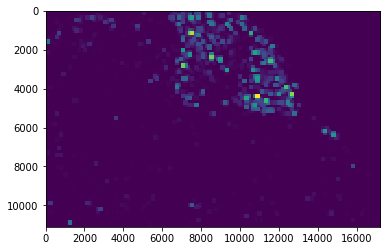

In [87]:
com = cv2.polylines(ks_map, [annotation.astype(np.int32)], True, [0, 255, 0], 50, lineType=8)
plt.imshow(com)

In [8]:
polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section_max).iterrows()]
cs = []
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()
    cs.append(polygon.astype(np.int32))

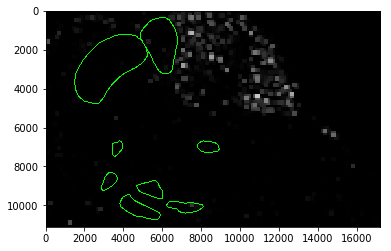

In [98]:
gray = hsv.copy() * 255
gray = gray.astype(np.uint8)
rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
com = cv2.polylines(rgb, cs, True, [0, 255, 0], 50, lineType=8)
plt.imshow(com)

In [99]:
map1 = hsv.copy()

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


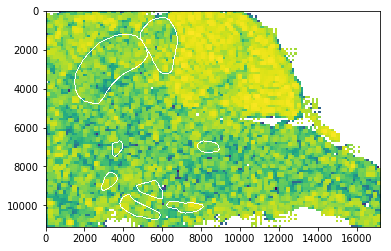

In [96]:
plt.imshow(np.log(com))

In [7]:
%%time
structure = 'Tz'
polygons = [(contour['section'], contour['vertices']) \
            for contour_id, contour in contours_struc.get_group(structure).iterrows()]
area_max = 0
for contour_id, contour in polygons:
    section = contour_id
    polygon = contour.copy()
    if Polygon(polygon).area>area_max:
        area_max = Polygon(polygon).area
        section_max = section
        polygon_max = polygon 
polygon = polygon_max

db_dir = 'CSHL_databases/' + stack + '/'
db_fp = db_dir + str(section_max) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()   

# [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
#                            int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
#                            int(max(min(polygon[:, 1]) - margin, 0)),
#                            int(min(np.ceil(max(polygon[:, 1]) + margin), m))]

raws = cur.execute('SELECT * FROM features')
info = np.array(list(raws))
locations = info[:, 1:3]
features_all = info[:, 3:]

# raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
# info = np.array(list(raws))
# locations = info[:, 1:3]
# features = info[:, 3:]
    

stride = 112
window_size = 224
xs, ys = np.meshgrid(np.arange(0, n, stride), np.arange(0, m, stride), indexing='xy')
windows = np.c_[xs.flat, ys.flat]
p_values = np.zeros((len(windows), 20))
samples = []
for i in range(20):
    x1, y1 = CDF(features_all[:,i])
    samples.append(x1)

hsv = np.zeros([m, n])
for index in range(len(windows)):
    wx = int(windows[index][0])
    wy = int(windows[index][1])
    indices_window = np.where((locations[:, 0] > wx) & (locations[:, 0] < wx + window_size) \
                              & (locations[:, 1] > wy) & (locations[:, 1] < wy + window_size))[0]
    if len(indices_window):
        cells = features_all[indices_window]
        eva = 0
        p_value = []
        for i in range(20):
            x1 = samples[i]
            x2, y2 = CDF(cells[:,i])
            value = stats.ks_2samp(x1, x2)[1]
            eva += - np.log(value)
            p_value.append(value)
        p_values[index] = np.array(p_value)
#         p_values.append(p_value)
        origin = hsv[wy: wy + window_size, wx: wx + window_size]
        satua_img = np.zeros_like(origin) + eva
        comp = np.absolute(origin) - np.absolute(satua_img)
        hsv[wy: wy + window_size, wx: wx + window_size] = origin * (comp >= 0) + satua_img * (comp < 0) 
plt.figure()
ks_map = hsv.copy()

com = cv2.polylines(ks_map, cs, True, [0, 255, 0], 50, lineType=8)
plt.imshow(com, cmap='gray')
# plt.title(structure)
plt.show()

ALREADY DOWNLOADED FILE


NameError: name 'cs' is not defined

<Figure size 432x288 with 0 Axes>

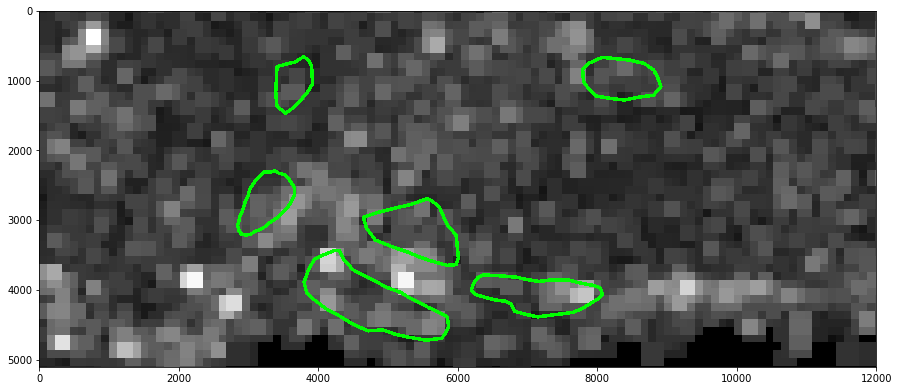

In [15]:
gray = hsv.copy() 
up = 6000
down = 6000
right = 12000
gray = gray[up:, :right]
gray = gray/gray.max()*255
gray = gray.astype(np.uint8)
rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
for i in range(len(cs)):
    annotation = cs[i].copy()
#     annotation[:, 0] = annotation[:, 0] - left
    annotation[:, 1] = annotation[:, 1] - up
    rgb = cv2.polylines(rgb, [annotation.astype(np.int32)], True, [0, 255, 0], 50, lineType=8)
plt.figure(figsize=(15,15))
plt.imshow(rgb)

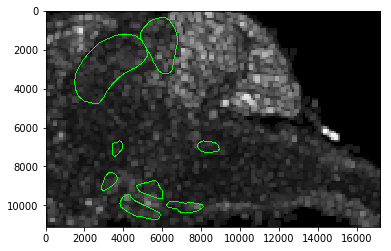

In [23]:
plt.imshow(rgb)

In [106]:
max(p_values)

280.5028294831506

ALREADY DOWNLOADED FILE


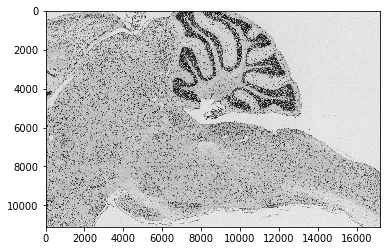

In [109]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section_max] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
plt.imshow(img, cmap='gray')

In [110]:
len(x1)

116800

In [112]:
from fitter import Fitter
f = Fitter(x1)
f.fit()

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted alpha distribution with error=0.0015217358576347132)
Fitted anglit distribution with error=0.01725101501675041)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


Fitted arcsine distribution with error=0.01545935543687312)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1625: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:7115: RuntimeWarning: divide by zero encountered in double_scalars
  return chi**3 / (_norm_pdf_C * _argus_phi(chi)) * x * np.sqrt(y) * np.exp(-chi**2 * y / 2)


Fitted argus distribution with error=0.018566884679835506)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=0.0017189247196938305)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:667: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:671: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


Fitted betaprime distribution with error=0.0014351342497198136)
Fitted bradford distribution with error=0.012036997530790591)
Fitted burr distribution with error=0.001511539855295664)
Fitted burr12 distribution with error=0.0013884292722233906)
Fitted cauchy distribution with error=0.0025058425228234654)
Fitted chi distribution with error=0.0033698426561948004)
Fitted chi2 distribution with error=0.0016962083497255613)
Fitted cosine distribution with error=0.01622112635128875)
Fitted crystalball distribution with error=0.005687548930331802)
Fitted dgamma distribution with error=0.002061992679473472)
Fitted dweibull distribution with error=0.0022429447909588524)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00025.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00016666666666666666.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0002777777777777778.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.000462962962962963.
  RuntimeWarning)
/Users/kuiqian

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.5186579178822165.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.5604451662992864.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.571462320591354.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.6304207421254922.
  RuntimeWarning)
/Users/kuiqia

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.0794646571239284.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.0223541899606783.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.0598307627054515.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 3.0319920155606983.
  RuntimeWarning)
/Users/kuiqi

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 2.1245671314996066.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.9453873835251927.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.8561074007297842.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.7879223174924603.
  RuntimeWarning)
/Users/kuiqi

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.804308169810441.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.8068226535279863.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.806712983896479.
  RuntimeWarning)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2651: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 1.8060902423390242.
  RuntimeWarning)
/Users/kuiqian

Fitted erlang distribution with error=0.0016962017315967114)
Fitted expon distribution with error=0.005800104648881633)
Fitted exponnorm distribution with error=0.0017808423764503001)
Fitted exponpow distribution with error=0.005583147141237922)
Fitted exponweib distribution with error=0.023159567930007202)
Fitted f distribution with error=0.0014351355882523144)
Fitted fatiguelife distribution with error=0.001513816919103399)
Fitted fisk distribution with error=0.0014869781042706714)
Fitted foldcauchy distribution with error=0.001806720207396493)
Fitted foldnorm distribution with error=0.0037045270005589444)
Fitted frechet_l distribution with error=0.002123363985855564)
Fitted frechet_r distribution with error=0.030009008541133156)
Fitted gamma distribution with error=0.12513393676995924)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:3175: RuntimeWarning: divide by zero encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


Fitted gausshyper distribution with error=0.011546410972065836)
Fitted genexpon distribution with error=0.0015288227297163516)
Fitted genextreme distribution with error=0.001521400666678245)
Fitted gengamma distribution with error=0.001460699237960731)
Fitted genhalflogistic distribution with error=0.0036012290276327737)
Fitted genlogistic distribution with error=0.002146681638115694)
Fitted gennorm distribution with error=0.002246192167513908)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2248: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted genpareto distribution with error=0.005284831278963414)
Fitted gilbrat distribution with error=0.002589616662967822)
Fitted gompertz distribution with error=0.004975766130611062)
Fitted gumbel_l distribution with error=0.011174647676666195)
Fitted gumbel_r distribution with error=0.002145214986154447)
Fitted halfcauchy distribution with error=0.0057295166000874455)
Fitted halfgennorm distribution with error=0.012434710523627405)
Fitted halflogistic distribution with error=0.0036102469395666824)
Fitted halfnorm distribution with error=0.003704519929395877)
Fitted hypsecant distribution with error=0.0031427073207841044)
Fitted invgamma distribution with error=0.0014954525019637008)
Fitted invgauss distribution with error=0.0015065183549557168)
Fitted invweibull distribution with error=0.001521399860670865)
Fitted johnsonsb distribution with error=0.0014697379835833455)
Fitted johnsonsu distribution with error=0.0014702992677753976)
Fitted kappa3 distribution with error=0.003066751

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:79: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


SKIPPED ksone distribution (taking more than 30 seconds)
Fitted kstwobign distribution with error=0.002786297733329613)
Fitted laplace distribution with error=0.002619419740221262)
Fitted levy distribution with error=0.00599947017673868)
Fitted levy_l distribution with error=0.019904514223103145)
SKIPPED levy_stable distribution (taking more than 30 seconds)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1625: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


SKIPPED loggamma distribution (taking more than 30 seconds)
Fitted logistic distribution with error=0.0036475777619353078)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4299: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)


Fitted loglaplace distribution with error=0.0017083507000491657)
SKIPPED lognorm distribution (taking more than 30 seconds)
SKIPPED lomax distribution (taking more than 30 seconds)
Fitted maxwell distribution with error=0.004317115329238547)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1618: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1618: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


SKIPPED mielke distribution (taking more than 30 seconds)
Fitted moyal distribution with error=0.0016605616360490785)
SKIPPED nakagami distribution (taking more than 30 seconds)
SKIPPED ncf distribution (taking more than 30 seconds)
SKIPPED nct distribution (taking more than 30 seconds)
SKIPPED ncx2 distribution (taking more than 30 seconds)
Fitted norm distribution with error=0.0056875488195217904)
SKIPPED norminvgauss distribution (taking more than 30 seconds)
Fitted pareto distribution with error=0.028467108370349888)
Fitted pearson3 distribution with error=0.0016962215342544227)
Fitted powerlaw distribution with error=0.013300675374780576)
SKIPPED powerlognorm distribution (taking more than 30 seconds)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5689: RuntimeWarning: divide by zero encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5689: RuntimeWarning: invalid value encountered in multiply
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5726: RuntimeWarning: divide by zero encountered in power
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5726: RuntimeWarning: invalid value encountered in multiply
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))


Fitted powernorm distribution with error=nan)
Fitted rayleigh distribution with error=0.003954075291531991)
Fitted rdist distribution with error=0.0056614971654639365)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
Fitted reciprocal distribution with error=0.021166608846238846)
Fitted rice distribution with error=0.003954081751874044)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=0.018006911885135358)
Fitted skewnorm distribution with error=0.002402326499460518)
Fitted t distribution with error=0.0025286562780338093)
Fitted trapz distribution with error=0.02223255823044056)
SKIPPED triang distribution (taking more than 30 seconds)
SKIPPED truncexpon distribution (taking more than 30 seconds)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6348: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6348: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


Fitted truncnorm distribution with error=0.021166608846238846)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


SKIPPED tukeylambda distribution (taking more than 30 seconds)
Fitted uniform distribution with error=0.017974678047298565)
SKIPPED vonmises distribution (taking more than 30 seconds)
SKIPPED vonmises_line distribution (taking more than 30 seconds)
Fitted wald distribution with error=0.0022647954428966803)
SKIPPED weibull_max distribution (taking more than 30 seconds)
SKIPPED weibull_min distribution (taking more than 30 seconds)


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/scipy/optimize/optimize.py:570: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


Fitted wrapcauchy distribution with error=nan)


In [127]:
dist_name = list(f.get_best().keys())[0]
param = f.get_best()[dist_name]
stats.kstest(x1, dist_name, args=param)

KstestResult(statistic=0.04156023515329871, pvalue=1.172576599777828e-175)

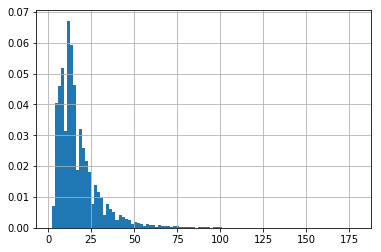

In [28]:
%%time
locations_all = []
features_all = []
locations_part = []
features_part = []

up = 6000
down = m
left = 0
right = 12000

for i in range(5):
    db_dir = 'CSHL_databases/' + stack + '/'
    db_fp = db_dir + str(section_max+i) + '.db'
    setup_download_from_s3(db_fp, recursive=False)
    conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
    cur = conn.cursor() 
    
    raws = cur.execute('SELECT * FROM features')
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    locations_all.extend(locations)
    features_all.extend(features)
    
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    locations_part.extend(locations)
    features_part.extend(features)

features_all = np.array(features_all)
features_part = np.array(features_part)
locations_all = np.array(locations_all)
locations_part = np.array(locations_part)

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
CPU times: user 6.79 s, sys: 512 ms, total: 7.3 s
Wall time: 7.65 s


In [29]:
features_all.shape, locations_all.shape, features_part.shape, locations_part.shape

((600274, 20), (600274, 2), (209740, 20), (209740, 2))

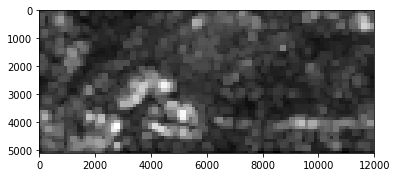

CPU times: user 1h 17min 32s, sys: 3min 7s, total: 1h 20min 39s
Wall time: 1h 24min 25s


In [30]:
%%time
stride = 112
window_size = 224
xs, ys = np.meshgrid(np.arange(left, right, stride), np.arange(up, down, stride), indexing='xy')
# xs, ys = np.meshgrid(np.arange(0, n, stride), np.arange(0, m, stride), indexing='xy')
windows = np.c_[xs.flat, ys.flat]
p_values = np.zeros((len(windows), 20))
samples = []
for i in range(20):
    x1, y1 = CDF(features_all[:,i])
    samples.append(x1)

hsv = np.zeros([m, n])
for index in range(len(windows)):
    wx = int(windows[index][0])
    wy = int(windows[index][1])
    indices_window = np.where((locations_part[:, 0] > wx) & (locations_part[:, 0] < wx + window_size) \
                              & (locations_part[:, 1] > wy) & (locations_part[:, 1] < wy + window_size))[0]
    if len(indices_window):
        cells = features_part[indices_window]
        eva = 0
        p_value = []
        for i in range(20):
            x1 = samples[i]
            x2, y2 = CDF(cells[:,i])
            value = stats.ks_2samp(x1, x2)[1]
            eva += - np.log(value)
            p_value.append(value)
        p_values[index] = np.array(p_value)
#         p_values.append(p_value)
        origin = hsv[wy: wy + window_size, wx: wx + window_size]
        satua_img = np.zeros_like(origin) + eva
        comp = np.absolute(origin) - np.absolute(satua_img)
        hsv[wy: wy + window_size, wx: wx + window_size] = origin * (comp >= 0) + satua_img * (comp < 0) 
plt.figure()
ks_map = hsv[up:down, left:right].copy()

# com = cv2.polylines(ks_map, cs, True, [0, 255, 0], 50, lineType=8)
plt.imshow(ks_map, cmap='gray')
# plt.title(structure)
plt.show()

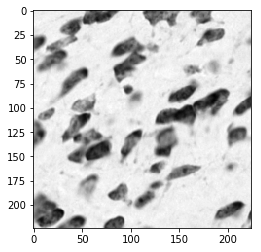

In [33]:
mask = hsv.copy()
part = img.copy()
# plt.figure(figsize=(15,15))
xmin = np.where(mask==mask.max())[1].min()
ymin = np.where(mask==mask.max())[0].min()
plt.imshow(part[ymin:ymin+window_size, xmin:xmin+window_size], cmap='gray')
# cv2.imwrite(savepath+'max_patch.png', part[ymin:ymin+window_size, xmin:xmin+window_size])

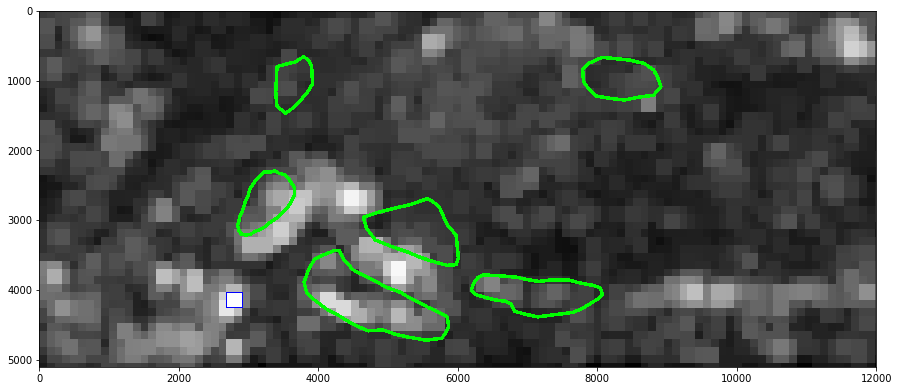

In [34]:
gray = hsv[up:down, left:right].copy()
gray = gray/gray.max()*255
gray = gray.astype(np.uint8)
rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
for i in range(len(cs)):
    annotation = cs[i].copy()
    annotation[:, 0] = annotation[:, 0] - left
    annotation[:, 1] = annotation[:, 1] - up
    rgb = cv2.polylines(rgb, [annotation.astype(np.int32)], True, [0, 255, 0], 50, lineType=8)
cv2.rectangle(rgb, (xmin-left, ymin-up), (xmin-left+window_size, ymin-up+window_size), [0,0,255], 14)
plt.figure(figsize=(15,15))
plt.imshow(rgb)
# cv2.imwrite(savepath+'KSmap.png', rgb)

In [36]:
mask.max()

378.9287428534402

In [38]:
%%time
wx = xmin
wy = ymin
indices_window = np.where((locations_part[:, 0] > wx) & (locations_part[:, 0] < wx + window_size) \
                              & (locations_part[:, 1] > wy) & (locations_part[:, 1] < wy + window_size))[0]
cells = features_part[indices_window]
eva = 0
foreground = []
for i in range(20):
    x1 = samples[i]
    x2, y2 = CDF(cells[:,i])
    value = stats.ks_2samp(x1, x2)[1]
    eva += - np.log(value)
    foreground.append(x2)
print(eva)

378.9287428534402
CPU times: user 982 ms, sys: 57.6 ms, total: 1.04 s
Wall time: 1.09 s


In [ ]:
%%time
trial = np.zeros([m, n])
for index in range(len(windows)):
    wx = int(windows[index][0])
    wy = int(windows[index][1])
    indices_window = np.where((locations_part[:, 0] > wx) & (locations_part[:, 0] < wx + window_size) \
                              & (locations_part[:, 1] > wy) & (locations_part[:, 1] < wy + window_size))[0]
    if len(indices_window):
        cells = features_part[indices_window]
        eva1 = 0
        eva2 = 0
        for i in range(20):
            x1 = samples[i]
            x2, y2 = CDF(cells[:,i])
            value = stats.ks_2samp(x1, x2)[1]
            eva1 += - np.log(value)
            
            x3 = foreground[i]
            value = stats.ks_2samp(x3, x2)[1]
            eva2 += - np.log(value)
#             p_value.append(value)
#         p_values[index] = np.array(p_value)
#         p_values.append(p_value)
        eva = 1*(eva1 >= eva2)
        origin = trial[wy: wy + window_size, wx: wx + window_size]
        satua_img = np.zeros_like(origin) + eva
        comp = np.absolute(origin) - np.absolute(satua_img)
        trial[wy: wy + window_size, wx: wx + window_size] = origin * (comp >= 0) + satua_img * (comp < 0) 
plt.figure()
ks_map = trial[up:down, left:right].copy()

com = cv2.polylines(ks_map, cs, True, [0, 255, 0], 50, lineType=8)
plt.imshow(com, cmap='gray')
# plt.title(structure)
plt.show()